In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, concat_ws, to_timestamp, date_format, size, split
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.ml.feature import VectorAssembler


In [2]:
#Read csv file to dataframe
spark = SparkSession.builder.getOrCreate()
df = spark.read.csv("gs://6893proj/crash_weather.csv", inferSchema=True, header=True)

df.show(1)

+-------------+--------+--------+---------+---------+--------------------+--------------------+-------------------------+------------------------+-----------------------------+----------------------------+-------------------------+------------------------+--------------------------+-------------------------+------------+--------------------+----------------+-------------------+------------------+---------+--------------+------------------+------------------+-------------------+--------------------+---------------------+-------------------+-----------------+--------------+-----------------+
|    simp_date| borough|zip code| latitude|longitude|            location|     off street name|number of persons injured|number of persons killed|number of pedestrians injured|number of pedestrians killed|number of cyclist injured|number of cyclist killed|number of motorist injured|number of motorist killed|collision_id|                date|            time|temperature_2m (°C)|precipitation (mm)|rain

In [3]:
df1 = df.select("simp_date", "latitude", "longitude", "borough")
df1.show(3)

+-------------+---------+---------+--------+
|    simp_date| latitude|longitude| borough|
+-------------+---------+---------+--------+
|2021-09-11 09|40.667202| -73.8665|BROOKLYN|
|2021-12-14 08| 40.86816|-73.83148|   BRONX|
|2021-12-14 21| 40.67172| -73.8971|BROOKLYN|
+-------------+---------+---------+--------+
only showing top 3 rows



In [4]:
df1 = df1.withColumn('month', split(df['simp_date'], '-').getItem(1))
df1 = df1.drop('simp_date')
df1.show(truncate=False)
df1.printSchema()

+------------------+----------+-------------+-----+
|latitude          |longitude |borough      |month|
+------------------+----------+-------------+-----+
|40.667202         |-73.8665  |BROOKLYN     |09   |
|40.86816          |-73.83148 |BRONX        |12   |
|40.67172          |-73.8971  |BROOKLYN     |12   |
|40.75144          |-73.97397 |MANHATTAN    |12   |
|40.675883999999996|-73.75577 |QUEENS       |12   |
|40.66684          |-73.78941 |QUEENS       |12   |
|40.68158          |-73.97463 |BROOKLYN     |12   |
|40.65068          |-73.95881 |BROOKLYN     |12   |
|40.87262          |-73.904686|BRONX        |12   |
|40.748917         |-73.993546|MANHATTAN    |12   |
|40.75373          |-73.88505 |QUEENS       |12   |
|40.63165          |-74.08762 |STATEN ISLAND|12   |
|40.623104         |-73.95809 |BROOKLYN     |12   |
|40.66576          |-73.9845  |BROOKLYN     |12   |
|40.687534         |-73.9775  |BROOKLYN     |12   |
|40.710957         |-73.951126|BROOKLYN     |12   |
|40.81813   

### BROOKLYN_spring

In [5]:
spring = df1.rdd.filter(lambda x: x[3]=='03' or x[3]=='04' or x[3]=='05')
spring = spring.filter(lambda x: x[2]=="BROOKLYN")
spring = spring.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
spring = spring.map(lambda x: [x[0], x[1]])

loc_spring = spring.toDF(["latitude","longitude"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_spring)
new_df.show()

+---------+----------+--------------------+
| latitude| longitude|            features|
+---------+----------+--------------------+
|40.642986| -74.01621|[40.642986,-74.01...|
|40.666256|-73.900215|[40.666256,-73.90...|
| 40.62417| -73.97048|[40.62417,-73.97048]|
|40.692356| -73.94282|[40.692356,-73.94...|
| 40.65011|-73.930214|[40.65011,-73.930...|
|40.631687|  -73.9205|[40.631687,-73.9205]|
|40.705738|-73.944695|[40.705738,-73.94...|
|40.637905|  -73.8878|[40.637905,-73.8878]|
|40.635063| -73.94788|[40.635063,-73.94...|
|40.676403| -73.96287|[40.676403,-73.96...|
|40.613926|-74.030174|[40.613926,-74.03...|
|40.635563| -73.89577|[40.635563,-73.89...|
|40.712284|-73.964005|[40.712284,-73.96...|
|40.637985|  -74.0076|[40.637985,-74.0076]|
| 40.67046| -73.88788|[40.67046,-73.88788]|
|40.668896| -73.95339|[40.668896,-73.95...|
| 40.63654| -73.97707|[40.63654,-73.97707]|
| 40.63947|-73.902756|[40.63947,-73.902...|
| 40.69538|-73.985115|[40.69538,-73.985...|
| 40.63063| -74.00923|[40.63063,

In [6]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+--------------------+----------+
| latitude| longitude|            features|prediction|
+---------+----------+--------------------+----------+
|40.642986| -74.01621|[40.642986,-74.01...|         1|
|40.666256|-73.900215|[40.666256,-73.90...|         0|
| 40.62417| -73.97048|[40.62417,-73.97048]|        15|
|40.692356| -73.94282|[40.692356,-73.94...|        17|
| 40.65011|-73.930214|[40.65011,-73.930...|         4|
|40.631687|  -73.9205|[40.631687,-73.9205]|        13|
|40.705738|-73.944695|[40.705738,-73.94...|        17|
|40.637905|  -73.8878|[40.637905,-73.8878]|         0|
|40.635063| -73.94788|[40.635063,-73.94...|         2|
|40.676403| -73.96287|[40.676403,-73.96...|        18|
|40.613926|-74.030174|[40.613926,-74.03...|         7|
|40.635563| -73.89577|[40.635563,-73.89...|         0|
|40.712284|-73.964005|[40.712284,-73.96...|        11|
|40.637985|  -74.0076|[40.637985,-74.0076]|         1|
| 40.67046| -73.88788|[40.67046,-73.88788]|        10|
|40.668896

In [7]:
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 40.6481091  -73.89797403]
[ 40.64011127 -74.00713214]
[ 40.62784488 -73.94632349]
[ 40.68221944 -73.91386761]
[ 40.65972564 -73.9231532 ]
[ 40.58326033 -73.98269954]
[ 40.68836059 -73.98144907]
[ 40.62521516 -74.02603947]
[ 40.65145631 -73.95368383]
[ 40.59011912 -73.95117856]
[ 40.6725733  -73.88063807]
[ 40.70614811 -73.95749594]
[ 40.72806938 -73.94843034]
[ 40.62487932 -73.92150423]
[ 40.67109845 -73.9932485 ]
[ 40.63642156 -73.97682754]
[ 40.61067645 -73.96474613]
[ 40.70283636 -73.93387393]
[ 40.67819302 -73.94946816]
[ 40.61108745 -73.99636755]


Text(0.5,1,'BROOKLYN_spring')

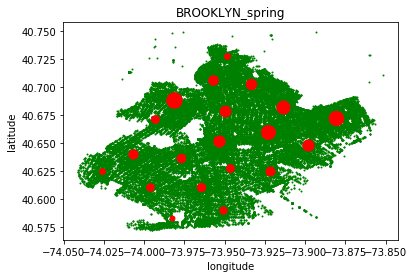

In [8]:
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[3]]+=1

    
loc = spring.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/300)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("BROOKLYN_spring")

### BROOKLYN_summer

In [9]:
summer = df1.rdd.filter(lambda x: x[3]=='06' or x[3]=='07' or x[3]=='08')
summer = summer.filter(lambda x: x[2]=="BROOKLYN")
summer = summer.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
summer = summer.map(lambda x: [x[0], x[1]])

loc_summer = summer.toDF(["latitude","longitude"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_summer)
new_df.show()

+---------+----------+--------------------+
| latitude| longitude|            features|
+---------+----------+--------------------+
|40.663303| -73.96049|[40.663303,-73.96...|
|40.631508| -73.90506|[40.631508,-73.90...|
| 40.64366| -73.90067|[40.64366,-73.90067]|
| 40.72937|-73.955444|[40.72937,-73.955...|
|40.683754| -73.88565|[40.683754,-73.88...|
|40.673676| -73.86576|[40.673676,-73.86...|
|40.731544|-73.955315|[40.731544,-73.95...|
|40.732006| -73.95795|[40.732006,-73.95...|
| 40.63874|  -73.8952| [40.63874,-73.8952]|
|40.682724| -73.88539|[40.682724,-73.88...|
| 40.59692| -73.94122|[40.59692,-73.94122]|
|40.731613|  -73.9545|[40.731613,-73.9545]|
|40.654343|-73.864204|[40.654343,-73.86...|
|40.715702| -73.95579|[40.715702,-73.95...|
|40.677155| -73.88773|[40.677155,-73.88...|
|40.730198|-73.954254|[40.730198,-73.95...|
| 40.67506| -73.98139|[40.67506,-73.98139]|
|40.720074| -73.96282|[40.720074,-73.96...|
|40.733376| -73.95865|[40.733376,-73.95...|
| 40.59714|-73.933495|[40.59714,

In [10]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+--------------------+----------+
| latitude| longitude|            features|prediction|
+---------+----------+--------------------+----------+
|40.663303| -73.96049|[40.663303,-73.96...|         7|
|40.631508| -73.90506|[40.631508,-73.90...|        18|
| 40.64366| -73.90067|[40.64366,-73.90067]|        18|
| 40.72937|-73.955444|[40.72937,-73.955...|         4|
|40.683754| -73.88565|[40.683754,-73.88...|         1|
|40.673676| -73.86576|[40.673676,-73.86...|         1|
|40.731544|-73.955315|[40.731544,-73.95...|         4|
|40.732006| -73.95795|[40.732006,-73.95...|         4|
| 40.63874|  -73.8952| [40.63874,-73.8952]|        18|
|40.682724| -73.88539|[40.682724,-73.88...|         1|
| 40.59692| -73.94122|[40.59692,-73.94122]|         6|
|40.731613|  -73.9545|[40.731613,-73.9545]|         4|
|40.654343|-73.864204|[40.654343,-73.86...|         1|
|40.715702| -73.95579|[40.715702,-73.95...|         4|
|40.677155| -73.88773|[40.677155,-73.88...|         1|
|40.730198

In [11]:
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 40.64718723 -73.95235372]
[ 40.67239418 -73.87549431]
[ 40.61057582 -73.99448647]
[ 40.636853   -73.97633796]
[ 40.71668956 -73.95418581]
[ 40.61499346 -73.95904429]
[ 40.58959748 -73.95184394]
[ 40.67904677 -73.95588859]
[ 40.67018876 -73.92834696]
[ 40.6886906  -73.98189917]
[ 40.7022169  -73.93922392]
[ 40.67157926 -73.90241232]
[ 40.6207048  -73.92632737]
[ 40.62511303 -74.02447107]
[ 40.64821483 -73.92144132]
[ 40.6931117  -73.91853148]
[ 40.64019344 -74.00673478]
[ 40.6713089  -73.99389474]
[ 40.64564168 -73.89595223]
[ 40.58298051 -73.98213928]


Text(0.5,1,'BROOKLYN_summer')

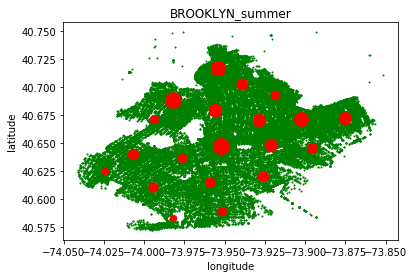

In [12]:
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[3]]+=1

    
loc = spring.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/300)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("BROOKLYN_summer")

### BROOKLYN_fall

In [13]:
fall = df1.rdd.filter(lambda x: x[3]=='09' or x[3]=='10' or x[3]=='11')
fall = fall.filter(lambda x: x[2]=="BROOKLYN")
fall = fall.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
fall = fall.map(lambda x: [x[0], x[1]])

loc_fall = fall.toDF(["latitude","longitude"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_fall)
new_df.show()

+---------+----------+--------------------+
| latitude| longitude|            features|
+---------+----------+--------------------+
|40.667202|  -73.8665|[40.667202,-73.8665]|
|40.617004| -73.96912|[40.617004,-73.96...|
|40.627735|-73.920105|[40.627735,-73.92...|
|  40.6843| -73.99724| [40.6843,-73.99724]|
|40.623913| -74.00726|[40.623913,-74.00...|
|  40.6783| -73.88988| [40.6783,-73.88988]|
|  40.6569|-73.907486|[40.6569,-73.907486]|
|40.648243|   -73.929| [40.648243,-73.929]|
|40.662037| -73.95077|[40.662037,-73.95...|
| 40.68164| -73.98568|[40.68164,-73.98568]|
|40.616295| -73.92991|[40.616295,-73.92...|
|40.609985| -73.96239|[40.609985,-73.96...|
|  40.6544| -73.92044| [40.6544,-73.92044]|
| 40.67393|-73.999954|[40.67393,-73.999...|
| 40.59841| -73.97592|[40.59841,-73.97592]|
| 40.67539| -73.88113|[40.67539,-73.88113]|
|40.599907| -73.94664|[40.599907,-73.94...|
|40.611477| -73.94883|[40.611477,-73.94...|
| 40.61578| -73.99995|[40.61578,-73.99995]|
| 40.67856|-73.889015|[40.67856,

In [14]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+--------------------+----------+
| latitude| longitude|            features|prediction|
+---------+----------+--------------------+----------+
|40.667202|  -73.8665|[40.667202,-73.8665]|        14|
|40.617004| -73.96912|[40.617004,-73.96...|        11|
|40.627735|-73.920105|[40.627735,-73.92...|        17|
|  40.6843| -73.99724| [40.6843,-73.99724]|        10|
|40.623913| -74.00726|[40.623913,-74.00...|         0|
|  40.6783| -73.88988| [40.6783,-73.88988]|         2|
|  40.6569|-73.907486|[40.6569,-73.907486]|         2|
|40.648243|   -73.929| [40.648243,-73.929]|         9|
|40.662037| -73.95077|[40.662037,-73.95...|        13|
| 40.68164| -73.98568|[40.68164,-73.98568]|        10|
|40.616295| -73.92991|[40.616295,-73.92...|        17|
|40.609985| -73.96239|[40.609985,-73.96...|        11|
|  40.6544| -73.92044| [40.6544,-73.92044]|         9|
| 40.67393|-73.999954|[40.67393,-73.999...|        10|
| 40.59841| -73.97592|[40.59841,-73.97592]|        19|
| 40.67539

In [15]:
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 40.61347741 -73.99558615]
[ 40.70423098 -73.95416184]
[ 40.67065141 -73.90081323]
[ 40.64197616 -73.89915117]
[ 40.64167302 -74.00605397]
[ 40.58757271 -73.96131148]
[ 40.62535908 -74.02420831]
[ 40.67321686 -73.92766242]
[ 40.63761276 -73.97690228]
[ 40.6524275  -73.92316656]
[ 40.68277108 -73.98752412]
[ 40.61480911 -73.96255933]
[ 40.59638364 -73.93893972]
[ 40.64758095 -73.9524533 ]
[ 40.67203266 -73.87541126]
[ 40.69763342 -73.9247472 ]
[ 40.72272653 -73.9475759 ]
[ 40.62381378 -73.92922842]
[ 40.67817381 -73.95829612]
[ 40.58756812 -73.9882096 ]


Text(0.5,1,'BROOKLYN_fall')

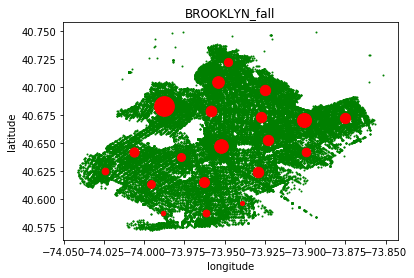

In [16]:
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[3]]+=1

    
loc = spring.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/300)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("BROOKLYN_fall")

### BROOKLYN_winter

In [17]:
winter = df1.rdd.filter(lambda x: x[3]=='12' or x[3]=='01' or x[3]=='02')
winter = winter.filter(lambda x: x[2]=="BROOKLYN")
winter = winter.filter(lambda x: x[0]!=0 and x[1]!=0 and x[0]!=None and x[1]!=None)
winter = winter.map(lambda x: [x[0], x[1]])

loc_winter = winter.toDF(["latitude","longitude"])

vecAssembler = VectorAssembler(inputCols=["latitude", "longitude"], outputCol="features")
new_df = vecAssembler.transform(loc_winter)
new_df.show()

+---------+----------+--------------------+
| latitude| longitude|            features|
+---------+----------+--------------------+
| 40.67172|  -73.8971| [40.67172,-73.8971]|
| 40.68158| -73.97463|[40.68158,-73.97463]|
| 40.65068| -73.95881|[40.65068,-73.95881]|
|40.623104| -73.95809|[40.623104,-73.95...|
| 40.66576|  -73.9845| [40.66576,-73.9845]|
|40.687534|  -73.9775|[40.687534,-73.9775]|
|40.710957|-73.951126|[40.710957,-73.95...|
| 40.59207| -73.96299|[40.59207,-73.96299]|
|40.665375|-73.934235|[40.665375,-73.93...|
|40.640835| -73.98967|[40.640835,-73.98...|
|40.658413|  -73.9171|[40.658413,-73.9171]|
|40.638523| -73.92607|[40.638523,-73.92...|
| 40.67392| -73.91012|[40.67392,-73.91012]|
|40.661263|-73.955765|[40.661263,-73.95...|
|40.687748|-73.980125|[40.687748,-73.98...|
|40.638428| -73.91275|[40.638428,-73.91...|
|40.591137| -73.97752|[40.591137,-73.97...|
| 40.63311| -73.97217|[40.63311,-73.97217]|
|40.644306| -74.01804|[40.644306,-74.01...|
|40.700233| -73.95988|[40.700233

In [18]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(new_df.select('features'))

transformed = model.transform(new_df)
transformed.show()

+---------+----------+--------------------+----------+
| latitude| longitude|            features|prediction|
+---------+----------+--------------------+----------+
| 40.67172|  -73.8971| [40.67172,-73.8971]|        15|
| 40.68158| -73.97463|[40.68158,-73.97463]|        18|
| 40.65068| -73.95881|[40.65068,-73.95881]|        14|
|40.623104| -73.95809|[40.623104,-73.95...|         5|
| 40.66576|  -73.9845| [40.66576,-73.9845]|         1|
|40.687534|  -73.9775|[40.687534,-73.9775]|        18|
|40.710957|-73.951126|[40.710957,-73.95...|         4|
| 40.59207| -73.96299|[40.59207,-73.96299]|        10|
|40.665375|-73.934235|[40.665375,-73.93...|        11|
|40.640835| -73.98967|[40.640835,-73.98...|        16|
|40.658413|  -73.9171|[40.658413,-73.9171]|         3|
|40.638523| -73.92607|[40.638523,-73.92...|         3|
| 40.67392| -73.91012|[40.67392,-73.91012]|        15|
|40.661263|-73.955765|[40.661263,-73.95...|        14|
|40.687748|-73.980125|[40.687748,-73.98...|        18|
|40.638428

In [19]:
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 40.64767436 -73.8941321 ]
[ 40.66726292 -73.99577439]
[ 40.62998498 -73.9457984 ]
[ 40.64727081 -73.91942709]
[ 40.70236459 -73.95398459]
[ 40.61358093 -73.96542546]
[ 40.63191155 -74.01810696]
[ 40.69701714 -73.92523378]
[ 40.61918963 -73.92280638]
[ 40.67254036 -73.87515331]
[ 40.59151448 -73.95068013]
[ 40.66857875 -73.92879054]
[ 40.67786457 -73.9549665 ]
[ 40.5846816  -73.98040568]
[ 40.65067831 -73.95438883]
[ 40.67380325 -73.90360284]
[ 40.63715443 -73.98298523]
[ 40.61096856 -73.99641838]
[ 40.68834404 -73.98288932]
[ 40.72130633 -73.94876311]


Text(0.5,1,'BROOKLYN_winter')

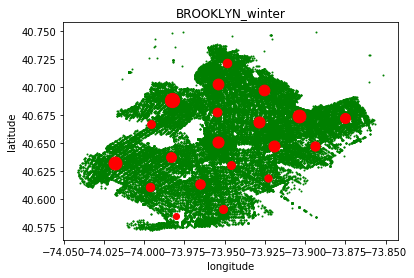

In [20]:
t = transformed.collect()

num = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for i in t:
    num[i[3]]+=1

    
loc = spring.collect()
x = []
y = []
for i in loc:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            x.append(i[0])
            y.append(i[1])
    
    
plt.plot(y,x,'go',markersize=1)

x_2 = []
y_2 = []
idx = 0
for j in centers:
    if i[1]>-74.05 and i[1]<-73.85:
        if i[0]>40.56 and i[0]<40.75:
            plt.plot(j[1],j[0],'ro',markersize=num[idx]/300)
            idx+=1
            
plt.ylabel("latitude")
plt.xlabel("longitude")
plt.title("BROOKLYN_winter")